Shape of Asset Returns (r_it): (500, 8)
Shape of Standardized Returns (Z): (500, 8)

--- Matrix Shapes ---
Sample Covariance Matrix shape: (8, 8)
Sample Correlation Matrix shape: (8, 8)

--- Sample Correlation Matrix (Top Left 4x4) ---
[[ 1.00000000e+00  2.34309784e-02  1.18691619e-02 -6.62937323e-04]
 [ 2.34309784e-02  1.00000000e+00 -7.30530565e-02  6.34771430e-02]
 [ 1.18691619e-02 -7.30530565e-02  1.00000000e+00 -8.14170461e-02]
 [-6.62937323e-04  6.34771430e-02 -8.14170461e-02  1.00000000e+00]]
Sorted Eigenvalues (lambda_i):
[1.18159979 1.15842699 1.10138609 1.06721766 0.94769086 0.90807478
 0.85578848 0.77981536]

Cumulative Variance Explained:
[0.14769997 0.29250335 0.43017661 0.56357882 0.68204017 0.79554952
 0.90252308 1.        ]

PCs needed for 80% variance: k = 7 PC(s)
PCs needed for 95% variance: k = 8 PC(s)


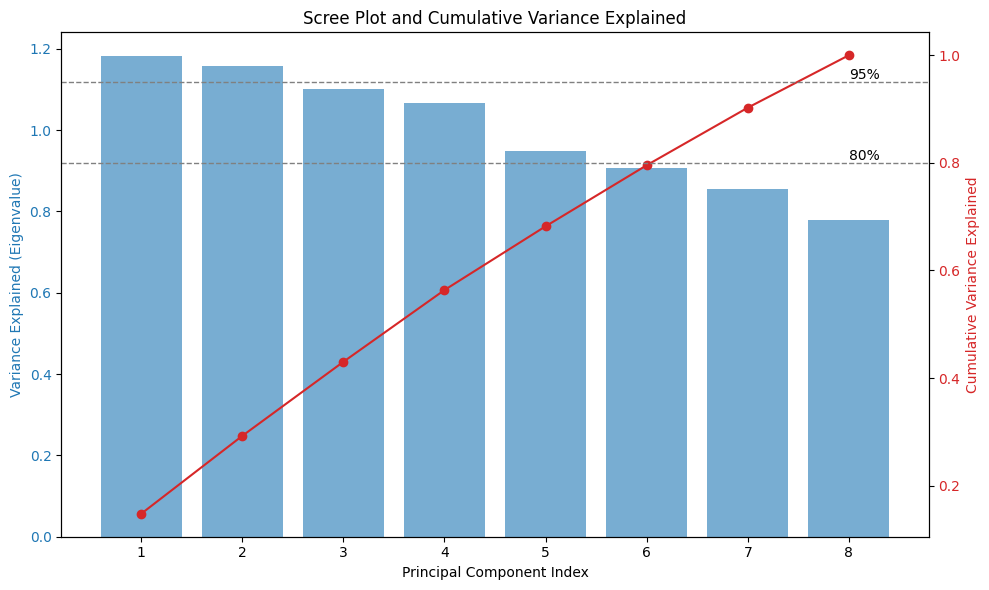


Shape of Original Returns (r_it): (500, 8)
Shape of Reconstructed Returns (r_hat) using k=7 PCs: (500, 8)


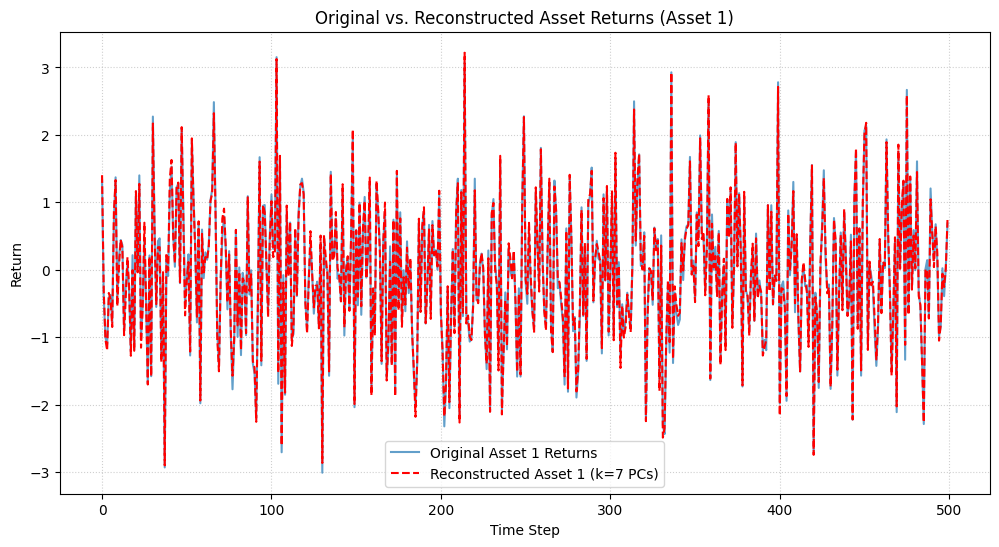


Normalised Reconstruction Error (Frobenius Norm): 0.3098


In [61]:
# --- PCA on Correlated Asset Returns & Reconstruction Error ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Data Generation ---

np.random.seed(42)
M = 8
T = 500

# --- Data Parameters ---

sigma_f = 0.01
sigma_e = 0.008
beta_i = np.random.uniform(low=0.6, high=1.2, size=(T, M))
e_it = np.random.standard_normal(size = (T, M))
f_t = np.random.normal(loc = 0, scale = sigma_f ** 2, size = (T, 1))
I = np.identity(T)

# --- Further Data Generation ---

r_it = beta_i * f_t + e_it
print(f"Shape of Asset Returns (r_it): {np.shape(r_it)}")

# --- Zero Mean Standardisation ---

mu_i = r_it.mean(axis=0)
s_i = r_it.std(axis=0)
Z = (r_it - mu_i) / s_i
print(f"Shape of Standardized Returns (Z): {np.shape(Z)}")

# --- Sample Covariance Simulation and Correlation Matrix Computation ---

sample_cov_r = np.cov(r_it, rowvar=False)
sample_corr_r = np.corrcoef(r_it, rowvar=False)
cov_Z = np.cov(Z, rowvar=False)

# --- Output Check ---

print("\n--- Matrix Shapes ---")
print(f"Sample Covariance Matrix shape: {sample_cov_r.shape}")
print(f"Sample Correlation Matrix shape: {sample_corr_r.shape}")

print("\n--- Sample Correlation Matrix (Top Left 4x4) ---")
print(sample_corr_r[:4, :4])

# --- PCA Performance via Eigen DSecomposition ---
eigenvalues, eigenvectors = np.linalg.eig(sample_corr_r)
idx = eigenvalues.argsort()[::-1]
lambda_i = eigenvalues[idx]
W = eigenvectors[:, idx]

print("Sorted Eigenvalues (lambda_i):")
print(lambda_i)

# --- Compute Variance Explained Ratios and Cumulative Variance ---

total_variance = np.sum(lambda_i)
M = len(lambda_i)
variance_explained_ratio = lambda_i / total_variance
cumulative_variance = np.cumsum(variance_explained_ratio)
target_80 = 0.80
target_95 = 0.95
k_80 = np.argmax(cumulative_variance >= target_80) + 1
k_95 = np.argmax(cumulative_variance >= target_95) + 1

print("\nCumulative Variance Explained:")
print(cumulative_variance)
print(f"\nPCs needed for 80% variance: k = {k_80} PC(s)")
print(f"PCs needed for 95% variance: k = {k_95} PC(s)")

# --- Data Visualisation ---

fig, ax1 = plt.subplots(figsize=(10, 6))
asset_indices = np.arange(1, M + 1)
color = 'tab:blue'
ax1.set_xlabel('Principal Component Index')
ax1.set_ylabel('Variance Explained (Eigenvalue)', color=color)
ax1.bar(asset_indices, lambda_i, color=color, alpha=0.6, label='Individual Variance')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(asset_indices)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Cumulative Variance Explained', color=color)
ax2.plot(asset_indices, cumulative_variance, color=color, marker='o', label='Cumulative Variance')
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(target_80, color='grey', linestyle='--', linewidth=1)
ax2.axhline(target_95, color='grey', linestyle='--', linewidth=1)
ax2.text(M, target_80, f'{target_80*100:.0f}%', va='bottom')
ax2.text(M, target_95, f'{target_95*100:.0f}%', va='bottom')
plt.title('Scree Plot and Cumulative Variance Explained')
fig.tight_layout()
plt.show()

# --- Reconstruct Returns using top k PCs (k = k_80) ---
k = k_80
Wk = W[:, :k]
r_centered = r_it - mu_i
P = r_centered @ Wk
r_reconstructed_centered = P @ Wk.T
r_hat = r_reconstructed_centered + mu_i
print(f"\nShape of Original Returns (r_it): {r_it.shape}")
print(f"Shape of Reconstructed Returns (r_hat) using k={k} PCs: {r_hat.shape}")

# --- Plot Original vs Reconstructed Series (e.g., Asset 1) ---
asset_index = 0
plt.figure(figsize=(12, 6))
plt.plot(r_it[:, asset_index], label=f'Original Asset {asset_index+1} Returns', alpha=0.7)
plt.plot(r_hat[:, asset_index], label=f'Reconstructed Asset {asset_index+1} (k={k} PCs)', linestyle='--', color='red')
plt.title(f'Original vs. Reconstructed Asset Returns (Asset {asset_index+1})')
plt.xlabel('Time Step')
plt.ylabel('Return')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()
reconstruction_error = np.linalg.norm(r_it - r_hat, 'fro') / np.linalg.norm(r_it, 'fro')
print(f"\nNormalised Reconstruction Error (Frobenius Norm): {reconstruction_error:.4f}")